# Hungarian Multi Rings

**Goal:** In the past notebooks
- `SA-mini`
- `SA-warm-up`

I've been focusing on a single ring to stay in a good range for the hyperparameters.

**Now:** Really understand what `scipy.optimize.linear_sum_assignment` function is doing.

I think the setup that I had from the earlier notebooks should be ok, but it's just a bit of syntax to follow-up on now :)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

import torch
import torch.nn.functional as F

from scipy.optimize import linear_sum_assignment

import os
os.sys.path.append('code')
from model import build_grid,SoftPositionalEmbed

%load_ext autoreload
%autoreload 2

## Toy problem for debugging

OK, this is great, but I think I can make this even a little bit simpler for debugging!

<img src="attn-2-rings-graphic.png" style="height:250px" align="left" />

In [2]:
true = torch.FloatTensor([[[1,0,0],[0,1,0]],
                          [[0,0,1],[0,1,0]]
                         ])
true.shape

torch.Size([2, 2, 3])

In [3]:
pred = torch.FloatTensor([[[.9,.4,0.],[.1,.1,.1],[0,.6,.9]],
                          [[.9,.3,0.],[.1,.5,.1],[.9,.3,0.]]
                         ])

pred.shape

torch.Size([2, 3, 3])

In [4]:
pred_flat = pred.flatten(0,1) # Shape batch_size * n_slots * pred_dim
pred_flat.shape

torch.Size([6, 3])

In [5]:
bs=2
k_slots = 3
n_rings_max = 2
enc_dim = 3

In [6]:
# flat_mask = true[:,None,:,:] 
# att = pred

# att_ext  = torch.tile(att,  dims=(1,1,n_rings_max,1)).reshape(bs * k_slots * n_rings_max , enc_dim) # nPixels**2)
# mask_ext = torch.tile(flat_mask,dims=(1,k_slots,1,1)).reshape(bs * k_slots * n_rings_max , enc_dim) #nPixels**2)

# pairwise_cost = F.binary_cross_entropy(att_ext,mask_ext,reduction='none').mean(axis=-1)
# pairwise_cost = pairwise_cost.reshape(bs, k_slots, n_rings_max)

# with torch.no_grad():
#     indices = list(map(linear_sum_assignment, pairwise_cost)) #np.array())
#     indices = torch.LongTensor(indices)
     
# # losses = pairwise_cost[torch.arange(bs),indices[:,0,0],indices[:,1,0]]

# # return torch.mean(losses)

In [7]:
# def hungarian_bce(att, mask,bs, k_slots,max_n_rings,nPxiels):
#     '''
#     Hungarian section Translated from the TensorFlow loss function (from 2006.15055 code):
#     https://github.com/nhartman94/google-research/blob/master/slot_attention/utils.py#L26-L57
#     '''
    
#     flat_mask = mask.reshape(-1,1, nPixels*nPixels)[:,None,:,:]
    
#     att_ext  = torch.tile(att,  dims=(1,1,max_n_rings,1)).reshape(bs * k_slots * max_n_rings , nPixels**2)
#     mask_ext = torch.tile(flat_mask,dims=(1,k_slots,1,1)).reshape(bs * k_slots * max_n_rings , nPixels**2)
    
#     pairwise_cost = F.binary_cross_entropy(att_ext,mask_ext,reduction='none').mean(axis=-1)
#     pairwise_cost = pairwise_cost.reshape(bs, k_slots, max_n_rings)
    
#     with torch.no_grad():
#         indices = list(map(linear_sum_assignment, pairwise_cost.cpu()))
#         indices = torch.LongTensor(indices)
    
#     losses = 0
#     for pi,(ri,ci) in zip(pairwise_cost,indices):
#         losses += pi[ri,ci].sum()
#     return losses / indices.shape[0]
    

**How to do `tf.gather_nd` in torch?**
- [post](https://discuss.pytorch.org/t/how-to-do-the-tf-gather-nd-in-pytorch/6445/2)

In [ ]:
pairwise_cost[0]

In [ ]:
row_ind, col_ind = indices[0]

In [ ]:
row_ind

In [ ]:
col_ind

In [ ]:
pairwise_cost[0][row_ind,col_ind]

In [ ]:
pairwise_cost[1]

### Modifying the function generation

In [10]:
nPixels = 32

xlow = -0.5
xhigh = 0.5
binWidth = (xhigh-xlow)/(nPixels+1)

stdlow = 0.01
stdhigh = 0.05

bins = np.arange(xlow,xhigh,binWidth)

nBins = len(bins)-1

In [11]:
def make_batch(
    bins=np.arange(xlow,xhigh,binWidth),
    N_events = 100000,
    N_clusters = 1,
    mean_var_cluster = np.log(0.001),
    sigma_var_cluster = 0.1,
    mean_lam_cluster = np.log(200.),
    sigma_lam_cluster = 1.,
    isRing=True,
    blurImage=False,
    xlow=-.5,
    xhigh=0.5,
    stdlow=0.01,
    stdhigh=0.05,
    device='cpu'
):
    '''
    Starts from Florian's `gen_events` function
    https://gitlab.lrz.de/neural_network_clustering/permutation_invariant_loss/-/blob/main/test_blur.ipynb
    
    But I wanted to return the occupancy maps that you multiply the OG image by to output partitioning
    of the image into the OG ring signals.
    '''

    eventHistograms = np.zeros(shape=(N_events, len(bins)-1, len(bins)-1,1) ) 
    
    eventMasks = np.zeros(shape=(N_events, N_clusters, len(bins)-1, len(bins)-1) ) 
    
    eventNumbers = np.zeros(N_events)

    nMaxClusters = N_clusters   
    
    eventInfo = np.zeros(shape=(N_events, nMaxClusters, 3))
    
    for iEvent in range(N_events):
        
        image = np.zeros_like(eventHistograms[iEvent,:,:,0])
        
        n_clusters = nMaxClusters

        eventNumbers[iEvent] += n_clusters
        eI = []
        
        for iCluster in range(min(n_clusters,nMaxClusters)):
            
            # how many events in this cluster
            lam_N_events_in_cluster = 200. 
            
            N_events_in_cluster = np.random.poisson(lam_N_events_in_cluster)

            # where is the cluster center
            cluster_center = np.random.uniform(low=xlow, high=xhigh, size=2)

            # what is the cluster spread
            var_cluster = np.random.uniform(stdlow,stdhigh) 
            
            cluster_events_x0 = np.random.normal(loc=0., scale=1., size=N_events_in_cluster)
            cluster_events_y0 = np.random.normal(loc=0., scale=1., size=N_events_in_cluster)

            if isRing:
                fact = np.sqrt(var_cluster/(cluster_events_x0**2+cluster_events_y0**2))
            else:
                fact = np.sqrt(var_cluster)

            cluster_events_x = cluster_events_x0*fact + cluster_center[0]
            cluster_events_y = cluster_events_y0*fact + cluster_center[1]
            
            # bin the events
            H, _, _ = np.histogram2d(cluster_events_x, cluster_events_y, bins=[bins,bins])

            eventMasks[iEvent,iCluster] = H.T
            image += H.T
                        
            eI.append(np.concatenate([cluster_center, [var_cluster]]))

        eventHistograms[iEvent,:,:,0] = np.copy(image)

        eventInfo[iEvent] = np.array(eI)
    
    # reshape eventHistograms
    eventHistograms = eventHistograms[:,None,:,:,0] # shape (bs, 1, nPixels, nPixels)
    
    eventMasks = np.where(eventHistograms>0,eventMasks/eventHistograms,eventMasks)
    
    return torch.FloatTensor(eventHistograms).to(device), \
           torch.FloatTensor(eventInfo).to(device), \
           torch.FloatTensor(eventMasks).to(device)

Let's consider:
- batch_size 4
- 2 rings
- 3 slots

In [12]:
max_n_rings = 2
device='cuda:0'

In [13]:
bs=2
X, Y, true = make_batch(bins, N_events=bs, N_clusters=max_n_rings,device=device)

<ipython-input-11-30a9e9839aa9>:83: RuntimeWarning: invalid value encountered in true_divide
  eventMasks = np.where(eventHistograms>0,eventMasks/eventHistograms,eventMasks)


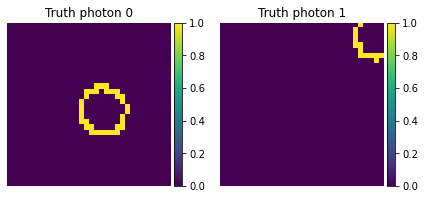

In [14]:
iEvt=1

fig, axs = plt.subplots(1,max_n_rings,figsize=(max_n_rings*3+1,3))

for i,ax in enumerate(axs):

    im = ax.imshow(true[iEvt,i].cpu().numpy(),vmin=0,vmax=1)

    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im, cax=cax, orientation='vertical')

    ax.set_title(f'Truth photon {i}')

    ax.axis('off')

plt.show()

**Define the model**

In [15]:
from torch.nn import init

In [16]:
k_slots=max_n_rings+1

In [17]:
model = SlotAttentionPosEmbed(k_slots=k_slots,device=device).to(device)

In [ ]:
with torch.no_grad():
    queries, att = model(X)

**Make a nice plotting function**

In [47]:
def plot_kslots(losses, mask, att, k_slots, color='C2',cmap='Greens'):
    
    fig, axs = plt.subplots(1,k_slots+2,figsize=(2.75 * (k_slots + 2) ,2.5))

    axs[0].plot(losses,color=color)
    axs[0].set_xlabel('Iters')
    axs[0].set_ylabel('Loss')
    
    imgs   = [mask] + [att[i] for i in range(k_slots)]
    titles = ['Target']+[f'Slot {i}' for i in range(k_slots)]
    
    for i, (ax,img,title) in enumerate(zip(axs[1:],imgs, titles)):
        
        im = ax.imshow(img,cmap=cmap,vmin=0,vmax=1)

        divider = make_axes_locatable(ax)
        cax = divider.append_axes('right', size='5%', pad=0.05)
        fig.colorbar(im, cax=cax, orientation='vertical')

        ax.set_title(title)

        ax.axis('off')
        
    plt.show()

Train the model!!

In [183]:
def train(model, Ntrain = 5000, bs=32, device='cpu', color='C2',cmap='Greens'):
    '''
    train
    -----------
    
    - model
    - Ntrain: # of training iterations
    - color,cmap -- options that get passed the
    '''

    # Learning rate schedule config
    base_learning_rate = 3e-4
    
    decay_rate = 0.5
    warmup_steps=1_000
    decay_steps = 2_000
    
    opt = torch.optim.Adam(model.parameters(), base_learning_rate)
    model.train()
    losses = []
    
    for i in range(Ntrain):

        learning_rate = base_learning_rate * decay_rate ** (i / decay_steps)
        # if i < warmup_steps:
        #     learning_rate *= (i / warmup_steps)
        
        opt.param_groups[0]['lr'] = learning_rate
        
        X, Y, mask = make_batch(N_events=bs, N_clusters=max_n_rings,device=device)
        
        queries, att = model(X)
            
        loss = hungarian_bce(att,mask,bs,model.k_slots,max_n_rings,nPixels)
        
        loss.backward()
        opt.step()
        opt.zero_grad()
        
        losses.append(float(loss))
        
        if i % 50 == 0:
            print('iter',i,', loss',loss.detach().cpu().numpy(),', lr',opt.param_groups[0]['lr'])
            
            iEvt = 0
            att_img = att[iEvt].reshape(model.k_slots,nPixels,nPixels)
            plot_kslots(losses, 
                        mask[iEvt].sum(axis=0).detach().cpu().numpy(), 
                        att_img.detach().cpu().numpy(),
                        k_slots, color=color,cmap=cmap)
            
            
            plot_kslots_iters(model, X, iEvt=0)
            plot_kslots_grads(model.gradients,iEvt=0)

    model.eval()
    return model,losses

In [60]:
class SlotAttentionPosEmbed(torch.nn.Module):
    def __init__(self, 
                 resolution=(32,32),
                 k_slots=3, 
                 hidden_dim=32, 
                 query_dim=32, 
                 n_iter=2,
                 device='cpu' 
                 ):
        '''
        Slot attention encoder block with positional embedding

        Inputs:
        - device (cpu, mps, cuda): Which device to put the model on 
                (needed for the random call when initializing the slots)
        - k_slots: number of slots (note, can vary between training and test time)
        - hidden_dim: The hidden dimension for the CNN (currently single layer w/ no non-linearities)
        - query_dim: The latent space dimension that the slots and the queries get computed in
        - n_iter: Number of slot attention steps to apply (defualt 2, and rn hard coded)
        '''
        super().__init__()

        self.k_slots = k_slots
        self.hidden_dim = hidden_dim
        self.query_dim = query_dim
        self.n_iter = n_iter

        self.device=device
        
        self.dataN = torch.nn.LayerNorm(self.hidden_dim)
        self.queryN = torch.nn.LayerNorm(self.query_dim)
        
        self.toK = torch.nn.Linear(self.hidden_dim, self.query_dim)
        self.toV = torch.nn.Linear(self.hidden_dim, self.query_dim)
        self.gru = torch.nn.GRUCell(self.query_dim, self.query_dim)

        filter_size=5
        self.CNN_encoder = torch.nn.Sequential(
            torch.nn.Conv2d(1,self.hidden_dim,filter_size, padding = 2),
            torch.nn.ReLU(),
            torch.nn.Conv2d(self.hidden_dim,self.hidden_dim,filter_size, padding = 2),
            torch.nn.ReLU(),
            torch.nn.Conv2d(self.hidden_dim,self.hidden_dim,filter_size, padding = 2),
        )
        
        self.posEnc = SoftPositionalEmbed(hidden_dim, resolution,device)
        
        self.init_mlp = torch.nn.Sequential(
            torch.nn.Linear(hidden_dim,hidden_dim),
            torch.nn.ReLU(),
            torch.nn.Linear(hidden_dim,hidden_dim)
        )
        
        self.slots_mu = torch.nn.Parameter(torch.randn(1, 1, self.query_dim))

        self.slots_logsigma = torch.nn.Parameter(torch.zeros(1, 1, self.query_dim))
        init.xavier_uniform_(self.slots_logsigma)
    
            
#     def init_slots(self, Nbatch):
#         noise = torch.randn(Nbatch, self.k_slots, self.query_dim).to(self.device)
        
#         mu = torch.zeros(1,1,self.query_dim).to(self.device)
#         logsigma = torch.zeros(1,1,self.query_dim).to(self.device)
        
#         return mu + noise*logsigma.exp()


    def init_slots(self,Nbatch):
        '''
        Slot init taken from
        https://github.com/lucidrains/slot-attention/blob/master/slot_attention/slot_attention.py
        '''
        mu = self.slots_mu.expand(Nbatch, self.k_slots, -1)
        sigma = self.slots_logsigma.exp().expand(Nbatch, self.k_slots, -1)

        return mu + sigma * torch.randn(mu.shape).to(self.device)

    def encoder(self,data):
        
        # Apply the CNN encoder
        encoded_data = self.CNN_encoder(data)
        
        # Put the channel dim at the end
        encoded_data = torch.permute(encoded_data,(0,2,3,1)) 
                 
        # Add the positional embeddings
        encoded_data = self.posEnc(encoded_data)
        
        # Flatten the pixel dims and apply the data normalization + MLP
        encoded_data = torch.flatten(encoded_data,1,2)
        encoded_data = self.dataN(encoded_data)
        encoded_data = self.init_mlp(encoded_data)
        
        return encoded_data
    
    # hook for the gradients of the activations
    def activations_hook(self, grad):
        self.gradients.append( grad )
    
    def attention_and_weights(self,queries,encoded_data):
        keys = self.toK(encoded_data)
        logits = torch.einsum('bse,bde->bsd',queries,keys) * (self.query_dim ** (-0.5)) #* 10
        # logits = torch.einsum('bse,bde->bsd',queries,keys) / self.query_dim 
        
        att = torch.nn.functional.softmax(logits, dim = 1)

        if att.requires_grad:
            h = logits.register_hook(self.activations_hook)
        
        div = torch.sum(att, dim = -1, keepdims = True)
        wts = att/div + 1e-8
        return att,wts

    def iterate(self, queries, encoded_data):
        
        # queries: (bs, k_slots, query_dim)
        
        att,wts = self.attention_and_weights(self.queryN(queries),encoded_data)   
        
        # att: (bs, k_slots, img_dim)
        # wts: (bs, k_slots, img_dim)
        
        vals = self.toV(encoded_data) # bs, img_dim, query_dim
        updates = torch.einsum('bsd,bde->bse',wts,vals) # bs, n_slots, query_dim
        
        updates = self.gru(
            updates.reshape(-1,self.query_dim),
            queries.reshape(-1,self.query_dim),
        )

        return updates.reshape(queries.shape)
        
    def forward(self, data):

        self.gradients = []
        
        Nbatch = data.shape[0]
        
        # Initialize the queries
        queries = self.init_slots(Nbatch) # Shape (Nbatch, k_slots, query_dim)
        
        encoded_data = self.encoder(data)
        
        for i in range(self.n_iter):
            queries = self.iterate(queries, encoded_data)    
            
        # Then with the _final_ query vector, calc what the attn + weights would be
        att, wts = self.attention_and_weights(self.queryN(queries),encoded_data)   
            
        return queries, att #.reshape(-1,self.k_slots,nPixels,nPixels)
    

In [42]:
def plot_kslots_iters(model, data, iEvt, color='C2',cmap='Greens'):
    '''
    Plot the attention masks across the iterations
    '''
    
    n_iter = model.n_iter
    k_slots = model.k_slots
    
    attn_masks = []

    with torch.no_grad():
        # Run through the model code to eval the attn masks
        queries = model.init_slots(data.shape[0]) 
        encoded_data = model.encoder(data)

        for i in range(n_iter):
            # Get the mask
            att,wts = model.attention_and_weights(model.queryN(queries), encoded_data) 
            attn_masks.append(att.detach().cpu())

            # Get the updated query
            queries = model.iterate(queries, encoded_data)

        # Get the final mask
        att,wts = model.attention_and_weights(model.queryN(queries), encoded_data) 
        attn_masks.append(att.detach().cpu())
    
    '''
    Make the plot
    '''
    fig, axs = plt.subplots(n_iter+1,k_slots,figsize=(2.75*k_slots,2.5*(n_iter+1)))
 
    for i, (ax_i, att) in enumerate(zip(axs, attn_masks)):
        
        att_img = att[iEvt].reshape(k_slots,nPixels,nPixels)
        
        for j, (ax, img) in enumerate(zip(ax_i,att_img)):
        
            im = ax.imshow(img,cmap=cmap)#,vmin=0,vmax=1)

            divider = make_axes_locatable(ax)
            cax = divider.append_axes('right', size='5%', pad=0.05)
            fig.colorbar(im, cax=cax, orientation='vertical')

            ax.set_title(f'T={i}: Slot {j}')

            ax.axis('off')
        
    plt.show()

In [103]:
def plot_kslots_grads(grads, iEvt, color='C2',cmap='Greens'):
    '''
    Plot the gradients across the attention maps
    '''
    
    n_iter = model.n_iter
    k_slots = model.k_slots
    
    '''
    Make the plot
    '''
    fig, axs = plt.subplots(n_iter+1,k_slots,figsize=(2.75*k_slots,2.5*(n_iter+1)))
 
    for i, ax_i, att in zip(range(n_iter+1)[::-1],axs, grads):
        
        att_img = att[iEvt].reshape(k_slots,nPixels,nPixels)
        
        for j, (ax, img) in enumerate(zip(ax_i,att_img)):
        
            im = ax.imshow(img.cpu().numpy(),cmap=cmap)#,vmin=0,vmax=1)

            divider = make_axes_locatable(ax)
            cax = divider.append_axes('right', size='5%', pad=0.05)
            fig.colorbar(im, cax=cax, orientation='vertical')

            ax.set_title(f'T={i}: Grad attn {j}')

            ax.axis('off')
        
    plt.show()

In [104]:
# plot_kslots_grads(model.gradients,0)

In [70]:
x=0

In [64]:
model.gradients[0] #.shape

tensor([[[ 7.5551e-05,  7.6605e-05,  7.7630e-05,  ...,  8.4990e-05,
           8.6943e-05,  8.7334e-05],
         [ 9.2204e-05,  9.1106e-05,  9.0045e-05,  ...,  8.2555e-05,
           8.0600e-05,  8.0197e-05],
         [-1.6775e-04, -1.6771e-04, -1.6767e-04,  ..., -1.6754e-04,
          -1.6754e-04, -1.6753e-04]]], device='cuda:0')

In [ ]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

<ipython-input-11-30a9e9839aa9>:83: RuntimeWarning: invalid value encountered in true_divide
  eventMasks = np.where(eventHistograms>0,eventMasks/eventHistograms,eventMasks)


iter 0 , loss 0.7938264 , lr 0.0003


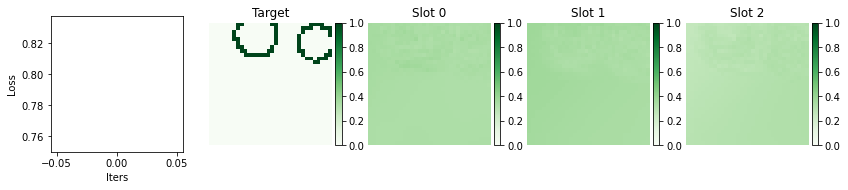

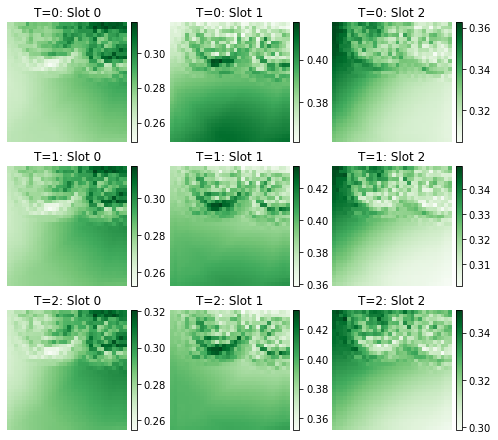

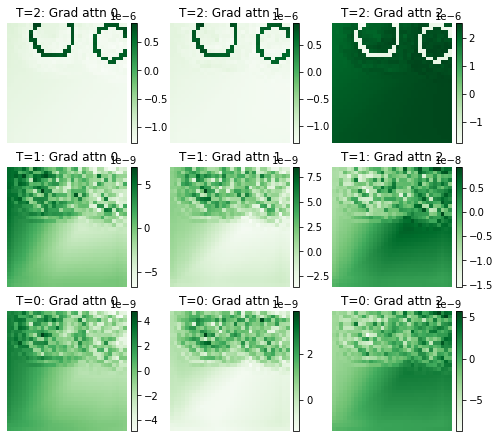

iter 50 , loss 0.35502464 , lr 0.0002948461795635753


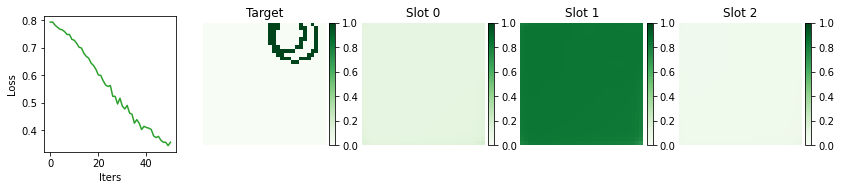

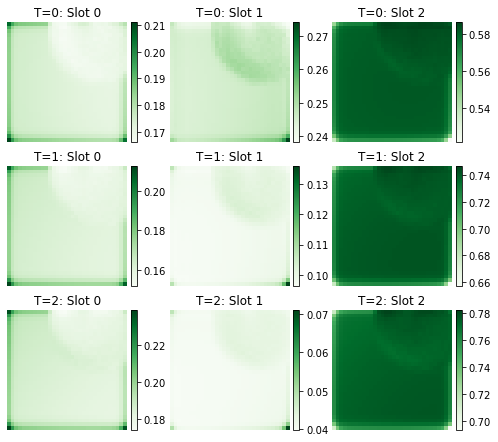

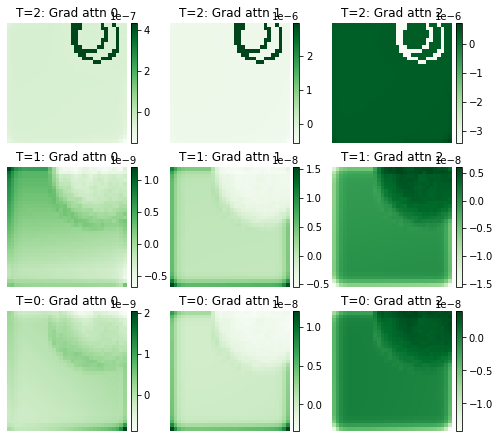

iter 100 , loss 0.23735702 , lr 0.00028978089867745364


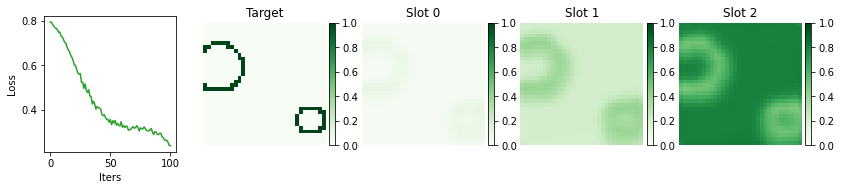

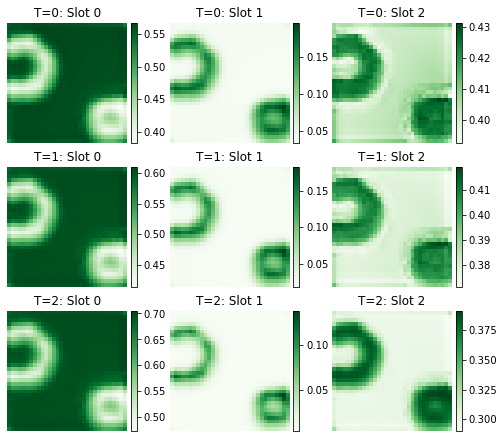

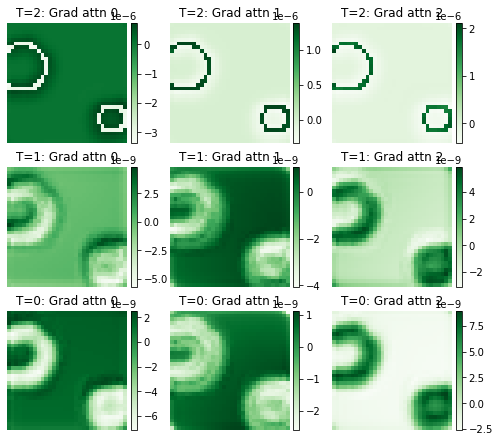

iter 150 , loss 0.109594174 , lr 0.0002848026362851557


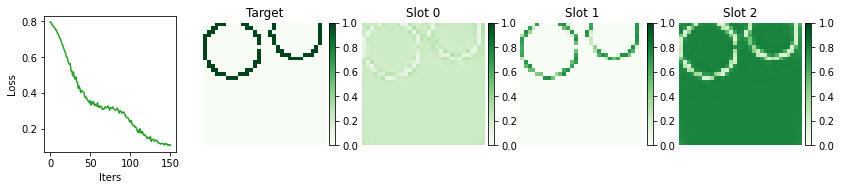

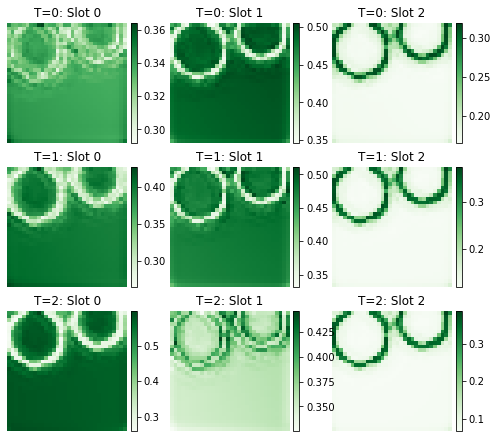

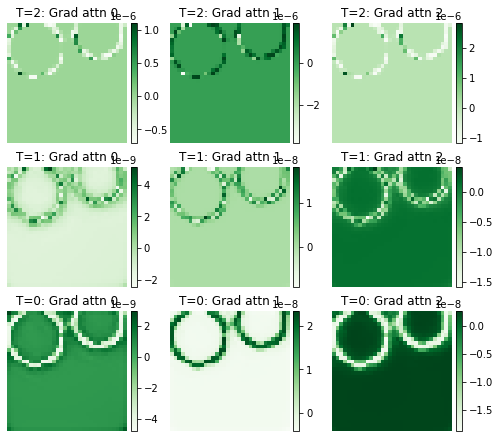

iter 200 , loss 0.08989028 , lr 0.0002799098974610422


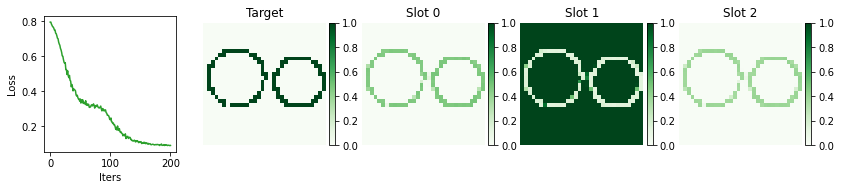

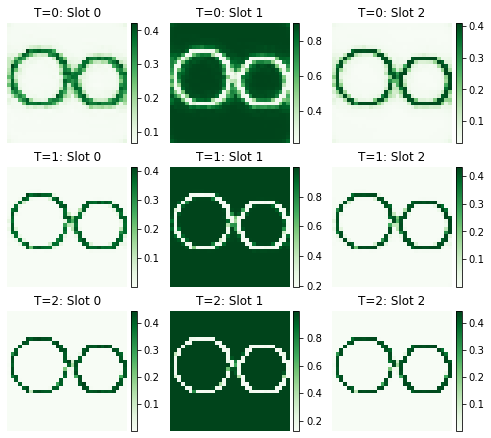

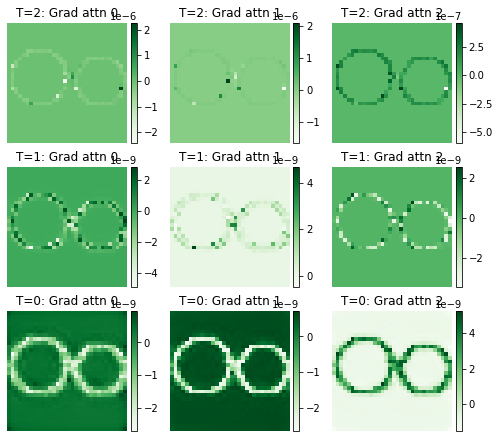

iter 250 , loss 0.08716904 , lr 0.0002751012129614013


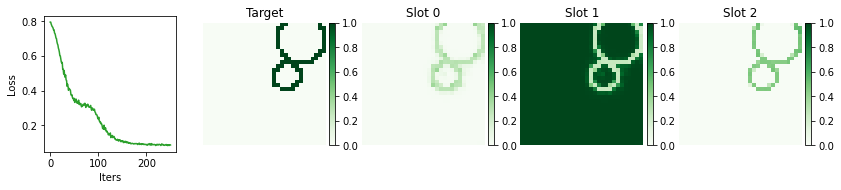

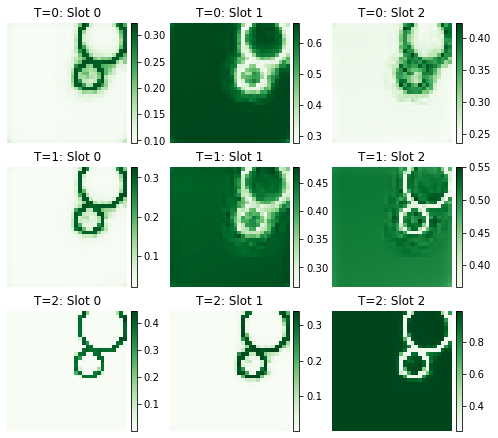

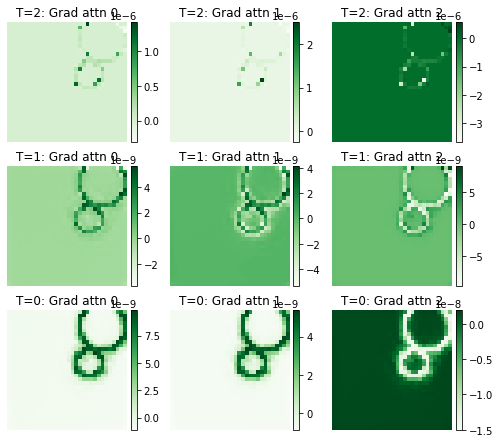

iter 300 , loss 0.088125914 , lr 0.00027037513878324905


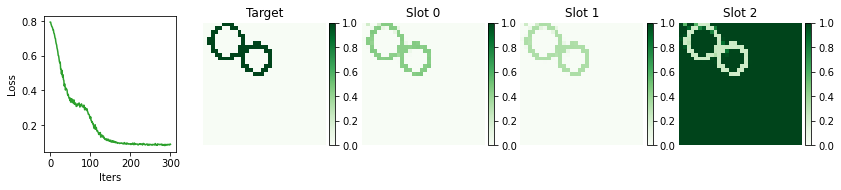

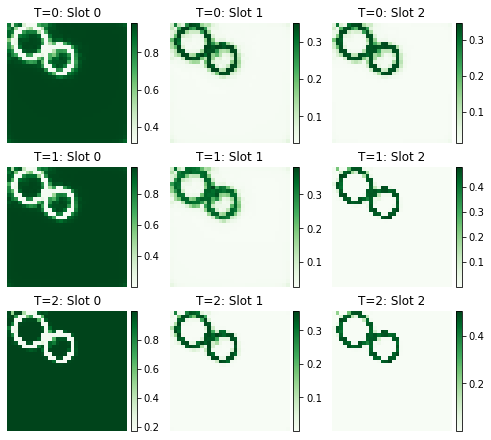

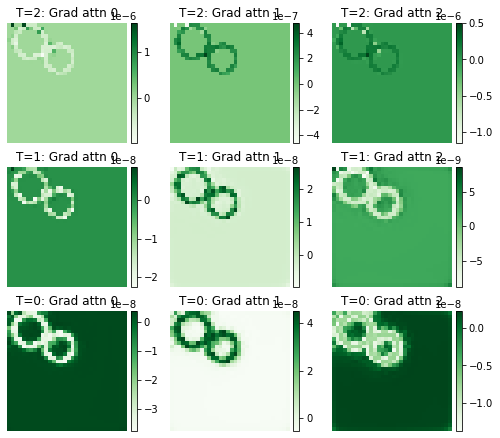

In [184]:
bs = 256
device='cuda:0'

model = SlotAttentionPosEmbed(k_slots=k_slots,device=device).to(device)

model,L = train(model, 301,bs=bs,device=device)

**OK, idk what's up... but I'm going to debug this!!**

In [86]:
mask.shape

torch.Size([1, 2, 32, 32])

In [148]:
def hungarian_matching(att, mask,bs, k_slots,max_n_rings,nPxiels):
    '''
    Hungarian section Translated from the TensorFlow loss function (from 2006.15055 code):
    https://github.com/nhartman94/google-research/blob/master/slot_attention/utils.py#L26-L57
    '''
    
    flat_mask = mask.reshape(-1,max_n_rings, nPixels*nPixels)[:,None,:,:]
    
    
    att_ext  = torch.tile(att,  dims=(1,1,max_n_rings,1)).reshape(bs * k_slots * max_n_rings , nPixels**2)
    mask_ext = torch.tile(flat_mask,dims=(1,k_slots,1,1)).reshape(bs * k_slots * max_n_rings , nPixels**2)
    
    pairwise_cost = F.binary_cross_entropy(att_ext,mask_ext,reduction='none').mean(axis=-1)
    pairwise_cost = pairwise_cost.reshape(bs, k_slots, max_n_rings)
    
    with torch.no_grad():
        indices = list(map(linear_sum_assignment, pairwise_cost.cpu()))
        indices = torch.LongTensor(indices)
    
        idx_mask = torch.zeros_like(pairwise_cost).bool()
        for i, pi,(ri,ci) in zip(range(bs),pairwise_cost,indices):
            idx_mask[i,ri,ci] = True
    
    # If there are a variable # of rings, I guess we could just multiply the
    # pairwise_cost matrix by some weights
    loss = torch.sum( pairwise_cost * idx_mask) / bs
        
    return loss
    

In [185]:
model = SlotAttentionPosEmbed(k_slots=k_slots,device=device).to(device)

In [192]:
bs=1

In [193]:
Ntrain=1

opt = torch.optim.Adam(model.parameters(), 3e-4)
model.train()
losses = []

for i in range(Ntrain):

    X, Y, mask = make_batch(N_events=bs, N_clusters=max_n_rings,device=device)

    queries, att = model(X)

#     loss = hungarian_bce(att,mask,bs,model.k_slots,max_n_rings,nPixels)

#     loss.backward()
#     opt.step()
#     opt.zero_grad()

#     losses.append(float(loss))

#     if i % 25 == 0:
#         print('iter',i,', loss',loss.detach().cpu().numpy(),', lr',opt.param_groups[0]['lr'])

#         iEvt = 0
#         att_img = att[iEvt].reshape(model.k_slots,nPixels,nPixels)
#         plot_kslots(losses, 
#                     mask[iEvt].sum(axis=0).detach().cpu().numpy(), 
#                     att_img.detach().cpu().numpy(),
#                     k_slots, color='C2',cmap='Greens')

<ipython-input-11-30a9e9839aa9>:83: RuntimeWarning: invalid value encountered in true_divide
  eventMasks = np.where(eventHistograms>0,eventMasks/eventHistograms,eventMasks)


In [194]:
model.gradients

[]

**Working throught the hungarian matching fct**

In [ ]:
def hungarian_matcher(att,):
    '''
    
    '''
    
    
    att_ext  = torch.tile(att,  dims=(1,1,max_n_rings,1)).reshape(bs * k_slots * max_n_rings , nPixels**2)
    mask_ext = torch.tile(flat_mask,dims=(1,k_slots,1,1)).reshape(bs * k_slots * max_n_rings , nPixels**2)

    pairwise_cost = F.binary_cross_entropy(att_ext,mask_ext,reduction='none').mean(axis=-1)
    pairwise_cost = pairwise_cost.reshape(bs, k_slots, max_n_rings)
 
    indices = list(map(linear_sum_assignment, pairwise_cost.cpu()))
    return [(torch.as_tensor(i, dtype=torch.int64), torch.as_tensor(j, dtype=torch.int64)) for i, j in indices]
 
#     indices = torch.LongTensor(indices)

#     idx_mask = torch.zeros_like(pairwise_cost).bool()
#     # If there are a variable # of rings, I guess we could just multiply the
#     # pairwise_cost matrix by some weights
#     for i, pi,(ri,ci) in zip(range(bs),pairwise_cost,indices):
#         idx_mask[i,ri,ci] = True
    
    

In [198]:
# flat_mask = mask.reshape(-1,max_n_rings, nPixels*nPixels)[:,None,:,:]
# with torch.no_grad():

#     att_ext  = torch.tile(att,  dims=(1,1,max_n_rings,1)).reshape(bs * k_slots * max_n_rings , nPixels**2)
#     mask_ext = torch.tile(flat_mask,dims=(1,k_slots,1,1)).reshape(bs * k_slots * max_n_rings , nPixels**2)

#     pairwise_cost = F.binary_cross_entropy(att_ext,mask_ext,reduction='none').mean(axis=-1)
#     pairwise_cost = pairwise_cost.reshape(bs, k_slots, max_n_rings)
 
#     indices = list(map(linear_sum_assignment, pairwise_cost.cpu()))
#     indices = torch.LongTensor(indices)

#     idx_mask = torch.zeros_like(pairwise_cost).bool()
#     # If there are a variable # of rings, I guess we could just multiply the
#     # pairwise_cost matrix by some weights
#     for i, pi,(ri,ci) in zip(range(bs),pairwise_cost,indices):
#         idx_mask[i,ri,ci] = True

#     # return pairwise_cost,indices,losses

In [206]:
?torch.index_select

Docstring:
index_select(input, dim, index, *, out=None) -> Tensor

Returns a new tensor which indexes the :attr:`input` tensor along dimension
:attr:`dim` using the entries in :attr:`index` which is a `LongTensor`.

The returned tensor has the same number of dimensions as the original tensor
(:attr:`input`).  The :attr:`dim`\ th dimension has the same size as the length
of :attr:`index`; other dimensions have the same size as in the original tensor.

.. note:: The returned tensor does **not** use the same storage as the original
          tensor.  If :attr:`out` has a different shape than expected, we
          silently change it to the correct shape, reallocating the underlying
          storage if necessary.

Args:
    input (Tensor): the input tensor.
    dim (int): the dimension in which we index
    index (IntTensor or LongTensor): the 1-D tensor containing the indices to index

Keyword args:
    out (Tensor, optional): the output tensor.

Example::

    >>> x = torch.randn(3, 4)


In [207]:
att.shape

torch.Size([1, 3, 1024])

In [205]:
torch.index_select(att,

SyntaxError: unexpected EOF while parsing (<ipython-input-205-2977f9a4c376>, line 1)

In [199]:
pairwise_cost

tensor([[[0.3660, 0.4825],
         [0.4189, 0.3627],
         [0.4838, 0.4170]]], device='cuda:0')

In [200]:
pairwise_cost[idx_mask]

tensor([0.3660, 0.3627], device='cuda:0')

In [201]:
torch.sum(pairwise_cost * idx_mask)

tensor(0.7287, device='cuda:0')

In [202]:
loss = (pairwise_cost * idx_mask).sum()

In [203]:
loss

tensor(0.7287, device='cuda:0')

In [176]:
# loss.backward()

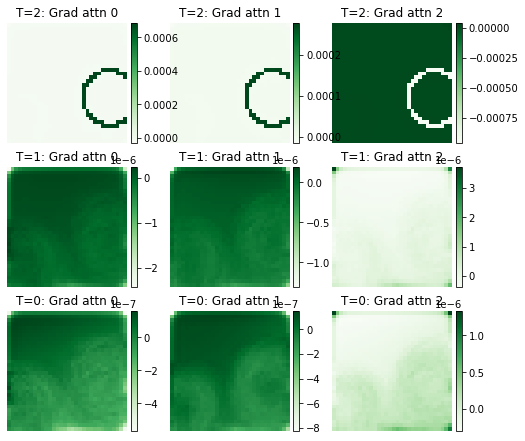

In [177]:
plot_kslots_grads(model.gradients,0)

In [178]:
pairwise_cost_all.mean(axis=-1).reshape(3,2)

tensor([[0.0868, 0.4408],
        [0.9506, 0.1273],
        [0.4326, 0.9447]], device='cuda:0')

In [179]:
with torch.no_grad():
    pairwise_cost_all = F.binary_cross_entropy(att_ext,mask_ext,reduction='none')

In [180]:
ri,ci

(tensor([1, 2]), tensor([0, 1]))

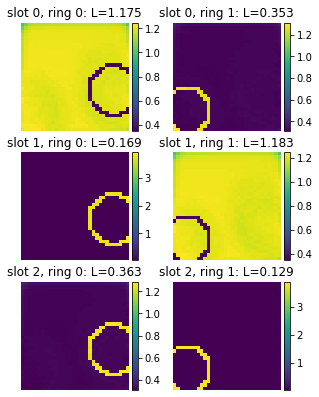

In [181]:
pi_img = pairwise_cost_all.reshape(3,2,nPixels,nPixels)

fig, ax = plt.subplots(3,2,figsize=(2.5*2,2.25*3))

for i in range(3):
    for j in range(2):
        im = ax[i,j].imshow(pi_img[i,j].detach().cpu().numpy())
          
        divider = make_axes_locatable(ax[i,j])
        cax = divider.append_axes('right', size='5%', pad=0.05)
        fig.colorbar(im, cax=cax, orientation='vertical')
 
        ax[i,j].set_title(f'slot {i}, ring {j}: L={pi_img[i,j].mean():.3f}')

        ax[i,j].axis('off')
        
plt.show()

In [182]:
pairwise_cost_all

tensor([[0.9869, 1.0641, 1.1235,  ..., 1.1882, 1.1801, 1.1472],
        [0.3968, 0.3732, 0.3536,  ..., 0.3341, 0.3366, 0.3483],
        [0.0462, 0.0341, 0.0277,  ..., 0.0210, 0.0217, 0.0237],
        [0.9869, 1.0641, 1.1235,  ..., 1.1882, 1.1801, 1.1472],
        [0.3968, 0.3732, 0.3536,  ..., 0.3341, 0.3366, 0.3483],
        [0.0462, 0.0341, 0.0277,  ..., 0.0210, 0.0217, 0.0237]],
       device='cuda:0')

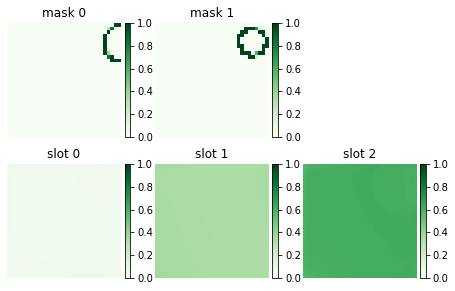

In [143]:
iEvt=0
cmap='Greens'

fig,axs = plt.subplots(2,k_slots,figsize=(2.5*k_slots,4.75))

for i,ax in enumerate(axs[0][0:max_n_rings]):

    im = ax.imshow(mask[0,i].detach().cpu(),cmap=cmap,vmin=0,vmax=1)

    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im, cax=cax, orientation='vertical')

    ax.set_title(f'mask {i}')

    ax.axis('off')

axs[0,max_n_rings].axis('off')
    
    
for i,ax in enumerate(axs[1]):

    im = ax.imshow(att[0,i].reshape(nPixels,nPixels).detach().cpu(),cmap=cmap,vmin=0,vmax=1)

    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im, cax=cax, orientation='vertical')

    ax.set_title(f'slot {i}')

    ax.axis('off')
    
plt.show()